In [244]:
from plotnine import *
import numpy as np
import pandas as pd

# This notebook helps to validate our tracings:

All times in ms!

In [267]:
! ls STATS/runner-001

config.fti			   timing-events.runner-001-app.0.csv
nulltime.runner-001-app.0.csv	   timing-events.runner-001-app.1.csv
nulltime.runner-001-app.1.csv	   timing-events.runner-001-head.0.csv
nulltime.runner-001-head.0.csv	   trace.runner-001-app.0.csv
runner-001.run-information.csv	   trace.runner-001-app.1.csv
runner-001.timing-information.csv  trace.runner-001-head.0.csv


In [310]:
STATS= 'STATS.lucky.with_sleep0'
STATS= 'STATS.2'
STATS= 'STATS'
runner = '001'
df_app = pd.read_csv(f'{STATS}/runner-{runner}/trace.runner-{runner}-app.0.csv')
df_app.head()

,rank,start_time,end_time,region,parameter
0,0,9992.719252,18402.823849,Propagation,-1
1,0,9991.087924,18402.840466,_INIT,0
2,0,18402.879758,18405.583790,_STORE,0
3,0,18405.588804,18911.919413,_CALC_WEIGHT,0
4,0,18911.943641,18912.064155,_PUSH_WEIGHT_TO_HEAD,0


In [311]:
# p = ggplot(df)
# p += geom_rect(aes(xmin='start_time', xmax='end_time', ymin=0, ymax=1, fill='region', group='region'), colour='black', alpha=0.5)
# p

## Runner 
### App Core

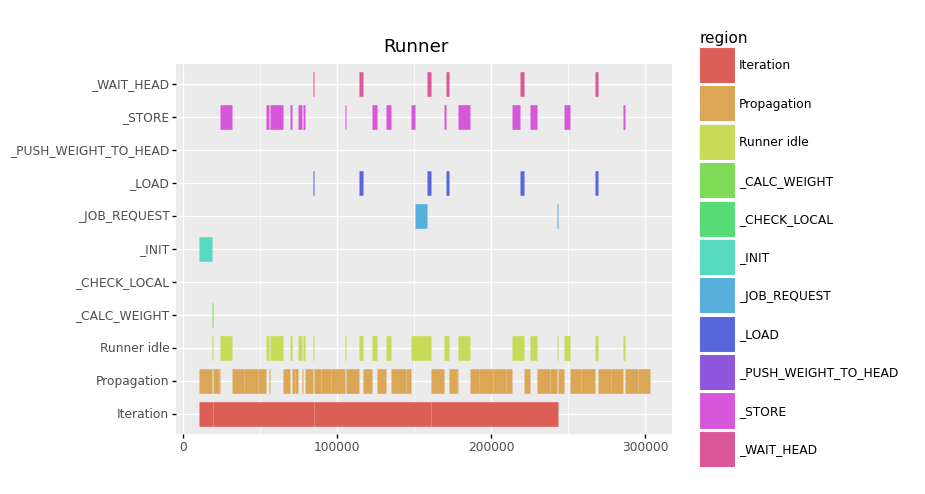

<ggplot: (-9223363291222743755)>

In [313]:
p = ggplot(df_app)

# rem: factor = pd.Categorical
p += geom_rect(aes(xmin='start_time', xmax='end_time', ymin='region',
                   ymax='region', 
                   fill='region', colour='region', line_pattern='region'), 
               size=10, alpha=1)
p += ggtitle("Runner")
p

- WAIT_HEAD and load is almost the same!
- WAIT head contains waiting for the head after a load request
- LOAD is loading until next calculation can stbe started
- iteration switches to the next if there is another assimilation_cycle that starts 
- job_request on rank0 contains communication to server + sync with other simulation ranks

### Propagation time seen from the app cores:

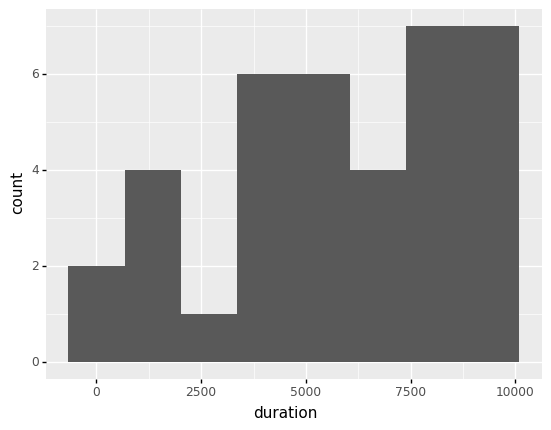

<ggplot: (-9223363291222668316)>

In [314]:
df_app['duration'] = df_app['end_time'] - df_app['start_time']
p = ggplot(df_app[df_app['region'] == 'Propagation'])

p += geom_histogram(aes(x='duration'), bins = 8)
#p += xlim(0,5)
p

## Local hits vs local misses:

In [315]:
df_ter = pd.read_csv(f'{STATS}/runner-{runner}/timing-events.runner-{runner}-app.0.csv')
# hits    /   (misses + hits)
len(df_ter[df_ter['event'] == 59]) / (len(df_ter[df_ter['event'] == 60]) + len(df_ter[df_ter['event'] == 59]))

0.8333333333333334

## Peer hits vs peer misses:

In [316]:
df_teh = pd.read_csv(f'{STATS}/runner-{runner}/timing-events.runner-{runner}-head.0.csv')
# hits    /   (misses + hits)
print(len(df_teh[df_teh['event'] == 56]) / (len(df_teh[df_teh['event'] == 56]) + len(df_teh[df_teh['event'] == 57])), 
      ',', len(df_teh[df_teh['event'] == 57]), 'misses')

0.0 , 26 misses


**This is a Problem!**
- could change with more slots / more runners
- could try to let it prefetch stuff that is on other runners?

### FTI HEAD

In [317]:
df_head = pd.read_csv(f'{STATS}/runner-{runner}/trace.runner-{runner}-head.0.csv')
df_head.head()

,rank,start_time,end_time,region,parameter
0,0,9990.515287,9992.942225,_INIT,0
1,0,19005.409270,19005.489749,_CHECK_LOCAL,0
2,0,19005.502919,19020.549273,_PUSH_STATE_TO_PFS,0
3,0,19030.097192,19034.824400,_PREFETCH_REQ,0
4,0,19030.041258,19034.844515,_PREFETCH,0


In [318]:
df_head[df_head['region'] == '_DELETE_PFS']

,rank,start_time,end_time,region,parameter


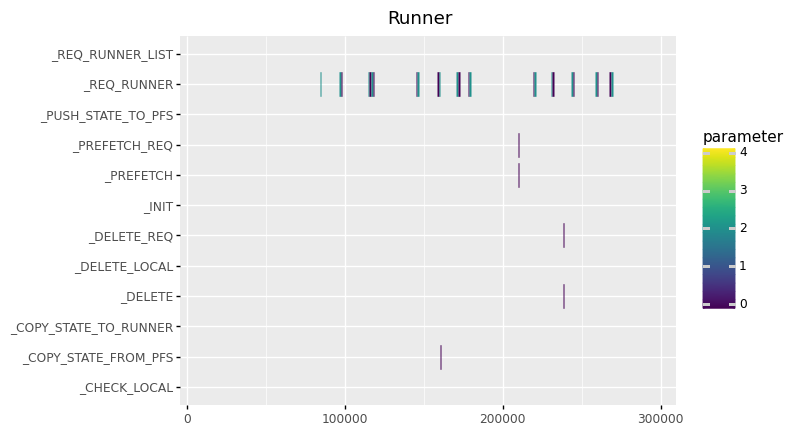

<ggplot: (-9223363291222100543)>

In [319]:
p = ggplot(df_head)

# rem: factor = pd.Categorical
p += geom_rect(aes(xmin='start_time', xmax='end_time', ymin='region',
                   ymax='region', 
                   fill='parameter', colour='parameter', line_pattern='region'), 
               size=10, alpha=1)
p += ggtitle("Runner")
p

## Server

In [320]:
!ls STATS

Global		      runner-000      runner-002
Local		      runner-000.log  runner-002.log
melissa_launcher.log  runner-001      server.log.1
Meta		      runner-001.log  trace.melissa_p2p_server.csv


In [321]:
df_server = pd.read_csv(f'{STATS}/trace.melissa_p2p_server.csv')
df_server

,start_time,end_time,region,parameter
0,19404.971123,19481.312275,Propagation,0
1,19374.437571,19490.583658,Propagation,1
2,19525.429010,19597.553492,Propagation,2
3,19597.557545,23081.679106,Runner Idle,2
4,23081.777573,23123.948097,Propagation,2
...,...,...,...,...
223,295877.015591,295923.788786,Propagation,1
224,290034.319639,297688.276768,Runner Idle,2
225,297688.467026,297760.299683,Propagation,2
226,293615.930319,301087.403059,Runner Idle,0


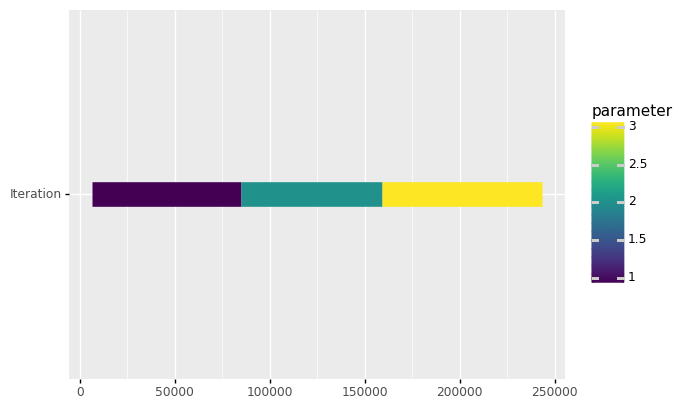

<ggplot: (8745514300182)>

In [322]:
p = ggplot(df_server[df_server['region'] == 'Iteration'])

# rem: factor = pd.Categorical
p += geom_rect(aes(xmin='start_time', xmax='end_time', ymin='region',
                   ymax='region', 
                   fill='parameter', colour='parameter'), 
               size=10, alpha=1)

p

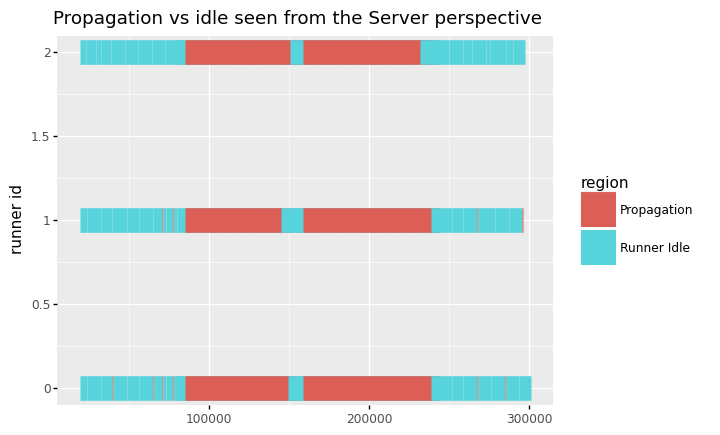

<ggplot: (8745504519814)>

In [323]:
p = ggplot(df_server[(df_server['region'] == 'Propagation') | (df_server['region'] == 'Runner Idle')])

# rem: factor = pd.Categorical
p += geom_rect(aes(xmin='start_time', xmax='end_time', ymin='parameter',
                   ymax='parameter', 
                   fill='region', colour='region'), 
               size=10, alpha=1)
p += ylab('runner id')
p += ggtitle("Propagation vs idle seen from the Server perspective")
p

## As Histogram:

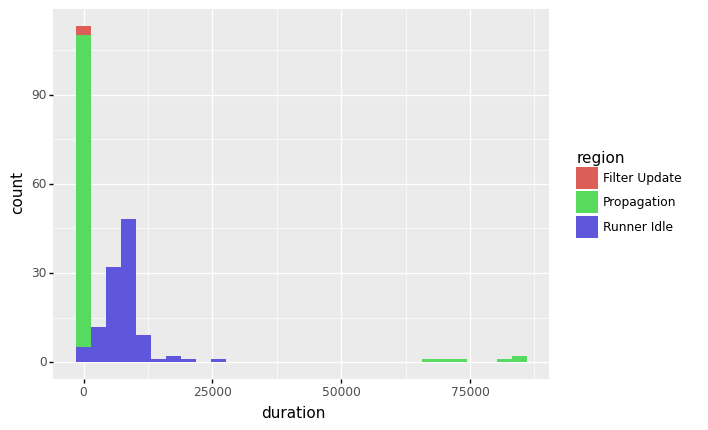

<ggplot: (8745509028886)>

In [324]:
df_server['duration'] = df_server['end_time'] - df_server['start_time']
p = ggplot(df_server[df_server['region'] != 'Iteration'])

p += geom_histogram(aes(x='duration', fill='region'), bins=30)
#p += xlim(0,5)
p

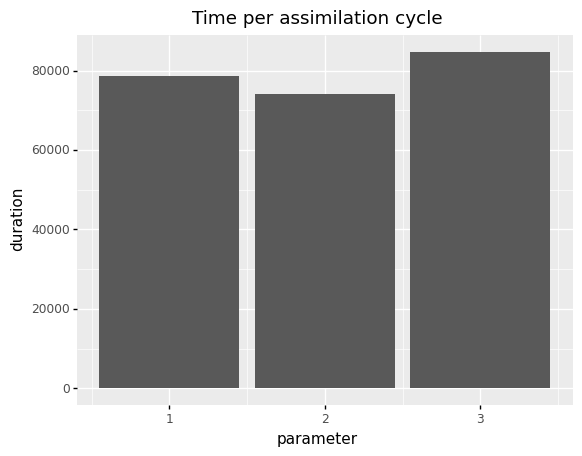

<ggplot: (-9223363291337847594)>

In [325]:
p = ggplot(df_server[df_server['region'] == 'Iteration'])

p += geom_col(aes(x='parameter', y='duration'))
#p += xlim(0,5)
p += ggtitle('Time per assimilation cycle')
p

In [326]:
df_server[df_server['region'] == 'Iteration']

,start_time,end_time,region,parameter,duration
58,6201.529503,84878.343821,Iteration,1,78676.814318
120,84878.345490,158935.046911,Iteration,2,74056.701422
182,158935.048342,243545.964241,Iteration,3,84610.915899
